In [ ]:
#%matplotlib
from classy import Class
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt
import scipy.integrate as sc

import scipy.interpolate



In [2]:

def simuler(mv_test, # eV
            kvec,k_special=1,factor = 2.68,T_ini = 1000,H0 = 67.040):
    
    Res = np.zeros(len(kvec))
    Res1 = np.zeros(len(kvec))
    Res2 = np.zeros(len(kvec))
    Res4 = np.zeros(len(kvec))
    Omega_M = 0.3
    Omega_R = 7e-5
    Omega_lambda = 1 - Omega_M - Omega_R
    Tv_k = 1.947
    # in MeV
    kb = 8.617e-11 # MeV/K
    T0 = Tv_k * kb
    # 
    h = 0.6704
    cosmo_dict ={'H0':H0, 'Omega_cdm':Omega_M, 'k_output_values':str(kvec).strip('[]'), "N_ncdm":1,
                 "m_ncdm":mv_test # massen er givet i eV s' jeg min egen test m_v skal være en faktor  1e-6 mindre
               ,'output':'tCl, lCl, dTk, vTk, pCl', 'lensing':'yes',
                "ncdm_fluid_approximation":3
                }
    H0 /= (3*1e5) # i 1/Mpc
    cosmo = Class()
    cosmo.set(cosmo_dict)
    cosmo.compute()
    bg = cosmo.get_background()
    pts = cosmo.get_perturbations()['scalar']
    #print(bg.keys())
    z = bg["z"]
    a = 1/(z+1)
    aend = a[-1]
    a0 = a[0]
    mv = mv_test * 1e-6
    # cs front faktoren
    


    # udregner Hubbleparameteren

    def H(a):
        return H0 * np.sqrt(Omega_lambda + Omega_M /( a **3) + Omega_R /( a**4)) 

    # udregnger tau 

    def tau_cal(a,y):
        # Vores "tids"-værdi i denne differentialligning er a
        tau = y[0]
        d_tau = 1 / (a ** 2 * H(a))
        return np.array(d_tau)

    # temperatur

    def Tv(a):
        return T0 / a # in MeV

    # lydhastighed

    def cs(a,mv,factor):
        return factor * Tv(a) / mv

    # udregn a
    def a_solve(tau,y):
        a = y[0]
        a_dt = a * a * H(a)
        return [a_dt]

    tau_init =   (1/H0) * (Omega_R ** (-0.5)) * a0


    sol_tau = sc.solve_ivp(tau_cal,t_span=[a0,aend],y0=[tau_init])
    tau = sol_tau.y[0]

    sol_a = sc.solve_ivp(a_solve,t_span=[tau[0],tau[-1]],y0=[a0])
    a_tau = sol_a.t
    a = sol_a.y[0]

    a_interp = scipy.interpolate.interp1d(a_tau,a)

    # simulerings funktionerne

    def func_det_hele(τ,y,k,mv,factor):
        delta = y[0]
        theta = y[1]    
        a = a_interp(τ)
        d_delta   = - theta
        d_theta      =  -  H(a) * a * theta    - (3/2) * H0*H0 * Omega_M * delta / a
        delta_nu = y[2]
        theta_nu = y[3]
        d_delta_nu   = - theta_nu
        d_theta_nu   =  -  H(a) * a * theta_nu - (3/2) * H0*H0 * Omega_M * delta / a  + k**2 * cs(a,mv,factor)**2 * delta_nu
        return [d_delta,d_theta,d_delta_nu,d_theta_nu]

    def func_del1(τ,y):
        delta = y[0]
        theta = y[1]    
        a = a_interp(τ)
        d_delta   = - theta
        #nabla2phi = 
        d_theta   =  - (3/2) * H0*H0 * Omega_M * delta / a-  H(a) * theta * a
        return [d_delta,d_theta]

    
    t_gem = T_ini
    for k_ind,k in enumerate(kvec):
        T_ini = t_gem
        
        delta_class = pts[k_ind]["delta_cdm"]
        theta_class = pts[k_ind]["theta_cdm"]
        tau_class = pts[k_ind]["tau [Mpc]"]
        delta_neutrino_class = pts[k_ind]["delta_ncdm[0]"]
        theta_neutrino_class = pts[k_ind]["theta_ncdm[0]"]
        a_class = pts[k_ind]["a"]
        if T_ini < tau_class[0]:
            print("Din T_ini er for lav.")
            print("T_ini sættes til lavest tau i class = %s ved k = %s" % (tau_class[0],k))
            T_ini = tau_class[0]
            #raise ValueError("T_ini=%s<tau[0]=%s" %(T_ini,tau_class[0]))
            
        delta_init = scipy.interpolate.interp1d(tau_class,delta_class)(T_ini)
        theta_init = scipy.interpolate.interp1d(tau_class,theta_class)(T_ini)
        delta_neutrino_init = scipy.interpolate.interp1d(tau_class,delta_neutrino_class)(T_ini)
        theta_neutrino_init = scipy.interpolate.interp1d(tau_class,theta_neutrino_class)(T_ini)
        
        
        τ_span = [T_ini,tau_class[-1]]

        y0 = [delta_init,theta_init,delta_neutrino_init,theta_neutrino_init]

        sol_en = sc.solve_ivp(func_det_hele, t_span = τ_span, y0 = y0,args=(k,mv,factor))

        τ_cdm_en = sol_en.t
        delta_cdm_en = sol_en.y[0]
        delta_nu_en = sol_en.y[2]

        Res[k_ind] = delta_nu_en[-1]
        Res4[k_ind] = delta_cdm_en[-1]
        # T-span1

        y01 = [delta_init,theta_init]

        sol_del1 = sc.solve_ivp(func_del1, t_span = τ_span, y0 = y01)

        τ_del1 = sol_del1.t

        delta_del1 = sol_del1.y[0]

        delta_cdm_interp = scipy.interpolate.interp1d(τ_del1,delta_del1)


        def func_del2(τ,y,k,mv,factor):
            delta = y[0]
            theta = y[1]    
            a = a_interp(τ)
            d_delta   = - theta
            delta_cdm = delta_cdm_interp(τ)
            d_theta   =  -  H(a) * a * theta - (3/2) * H0*H0 * Omega_M * delta_cdm / a  + k**2 * cs(a,mv,factor)**2 * delta
            return [d_delta,d_theta]

        y01_neutrino = [delta_neutrino_init,theta_neutrino_init]
        
        sol_neu1 = sc.solve_ivp(func_del2, t_span = τ_span, y0 = y01_neutrino,args=(k,mv,factor))
        
        Res1[k_ind] = sol_neu1.y[0][-1]
        Res2[k_ind] = delta_del1[-1]
        
        if k == k_special:
            plt.figure(3214)
            plt.loglog(tau_class,-delta_class,label="class cdm")
            plt.loglog(sol_neu1.t,-sol_neu1.y[0],label="alene neutrino")
            plt.loglog(τ_del1,-delta_del1,label="alene cdm")
            plt.loglog(τ_cdm_en,-delta_cdm_en,"-",label="cdm samlet")
            plt.loglog(τ_cdm_en,-delta_nu_en,"-.",label="neu samlet")
            plt.loglog(tau_class,-delta_neutrino_class,label="class neu")
            plt.xlabel("tau")
            plt.legend()
            plt.title(r"$m_{\nu}=$%s eV k=%s cs-factor = %s" % (mv_test,k_special,factor))
    
    
    tranf = cosmo.get_transfer(z=0)
    #print(tranf.keys())
    prim = cosmo.get_primordial()
    #print(prim.keys())

    k = tranf['k (h/Mpc)'] * h
    kvec = np.array(kvec)
    prim_interp = scipy.interpolate.interp1d(prim["k [1/Mpc]"],prim["P_scalar(k)"], fill_value="extrapolate",kind="cubic")

    # løs alt sammentidig

    # plot det hele
    plt.figure(1)

    plt.loglog(k, 2*np.pi**2 * tranf["d_ncdm[0]"] ** 2* k ** (-3) * prim_interp(k) * h ** 3,"-.",label="neutrino")
    plt.loglog(k, 2*np.pi**2 * tranf["d_m"] ** 2 * k ** (-3) *  prim_interp(k) * h ** 3,"-.",label="matter")
    plt.loglog(kvec,2*np.pi**2 * Res2** 2 * kvec**(-3) * prim_interp(kvec) * h ** 3,"--",label="min hver for sig matter")
    plt.loglog(kvec,2*np.pi**2 * Res4** 2 * kvec**(-3) * prim_interp(kvec) * h ** 3,"-.",label="samlet matter")
    plt.loglog(kvec,2*np.pi**2 * Res ** 2 * kvec**(-3) * prim_interp(kvec) * h ** 3,label="min samlet neu")
    plt.loglog(kvec,2*np.pi**2 * Res1** 2 * kvec**(-3) * prim_interp(kvec) * h ** 3,"-.",label="min hver for sig neu")
    
    plt.xlabel("k")
    plt.title("mv = %s eV T_ini = %s cs-factor = %s "%(mv_test,T_ini,factor))
    plt.legend()
    plt.xlim([kvec[0],kvec[-1]])
    
    
    return None



[0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 2, 3, 4, 5, 6, 10.0]


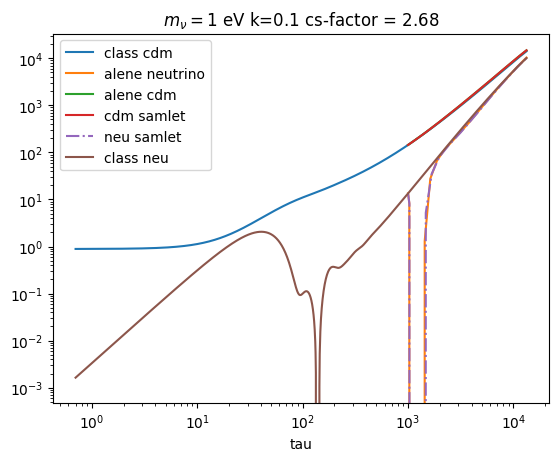

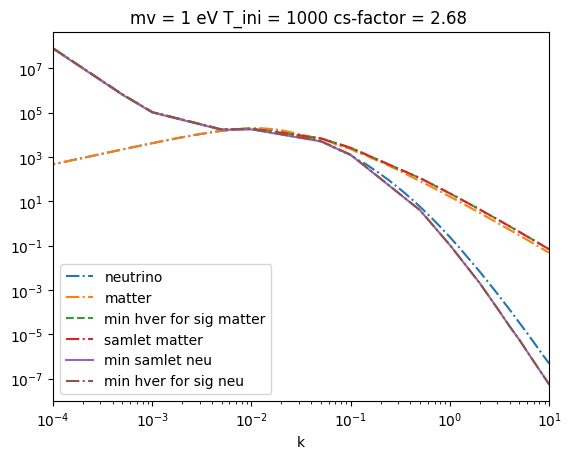

In [3]:
mv = 1

kvec = [1e-4,5e-4,1e-3,5e-3,1e-2,5e-2,1e-1,5e-1,1,2,3,4,5,6,1e1]
print(kvec)
a = simuler(mv,kvec=kvec,k_special=0.1,T_ini=1000)
a

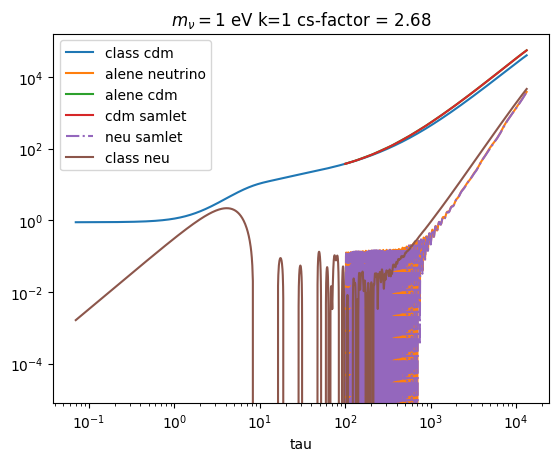

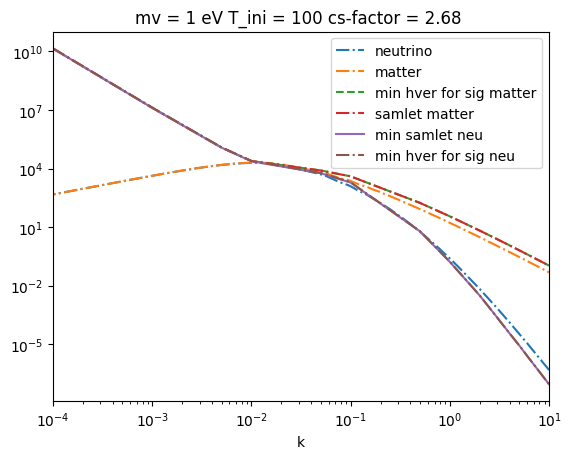

In [4]:
b = simuler(mv,kvec=kvec,T_ini=100)
b

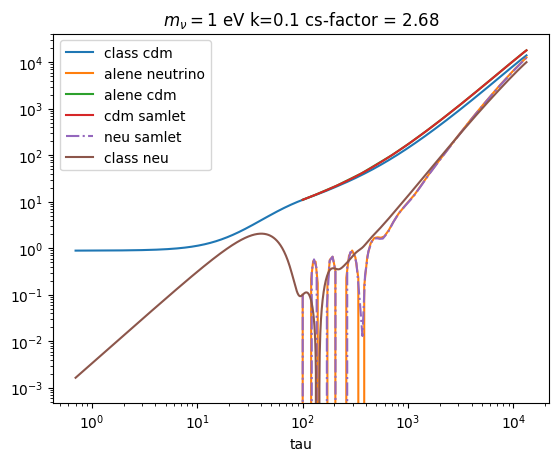

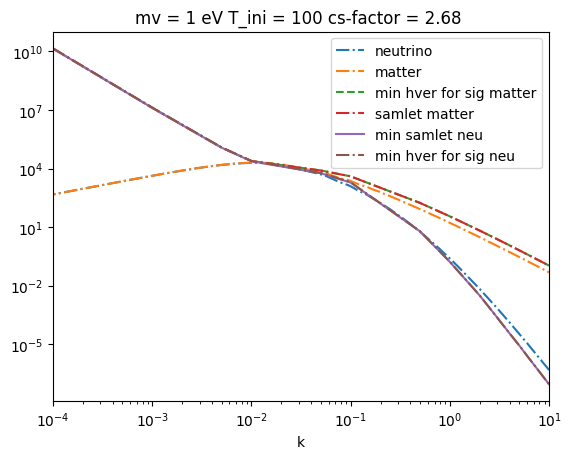

In [5]:
c = simuler(mv,kvec=kvec,T_ini=100,k_special=1e-1)

c


Din T_ini er for lav.
T_ini sættes til lavest tau i class = 10.415792524773943 ved k = 0.0001
Din T_ini er for lav.
T_ini sættes til lavest tau i class = 10.410993084536072 ved k = 0.0005
Din T_ini er for lav.
T_ini sættes til lavest tau i class = 10.410843102028567 ved k = 0.001
Din T_ini er for lav.
T_ini sættes til lavest tau i class = 10.410795107626466 ved k = 0.005


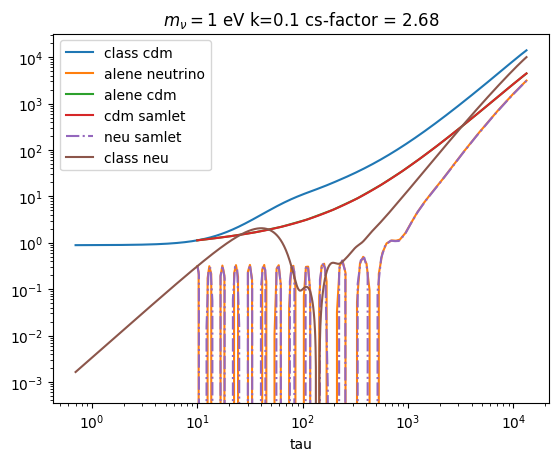

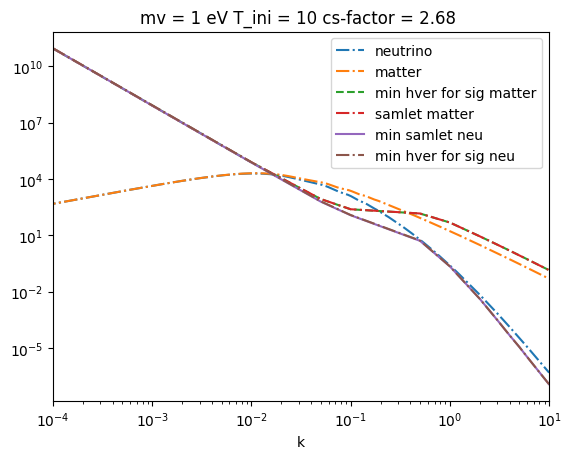

In [6]:
g = simuler(mv,kvec=kvec,T_ini=10,k_special=1e-1)

g


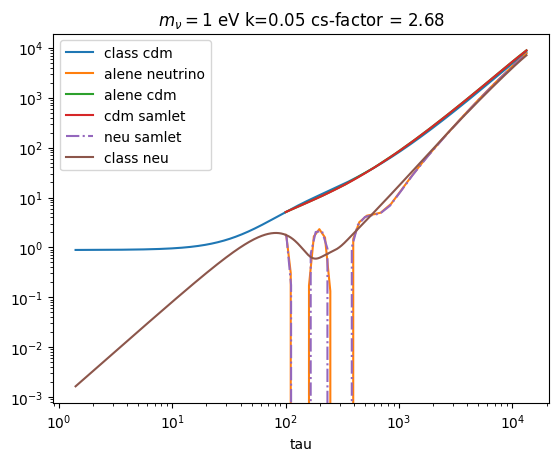

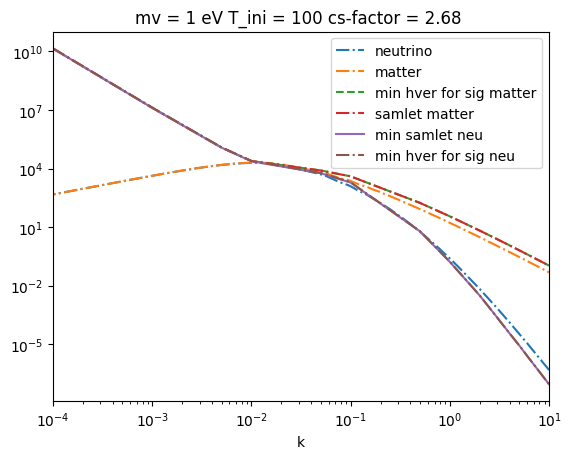

In [7]:
d = simuler(mv,kvec=kvec,T_ini=100,k_special=5e-2)
d

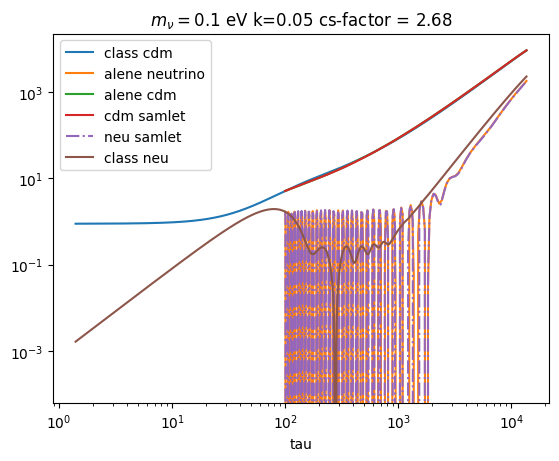

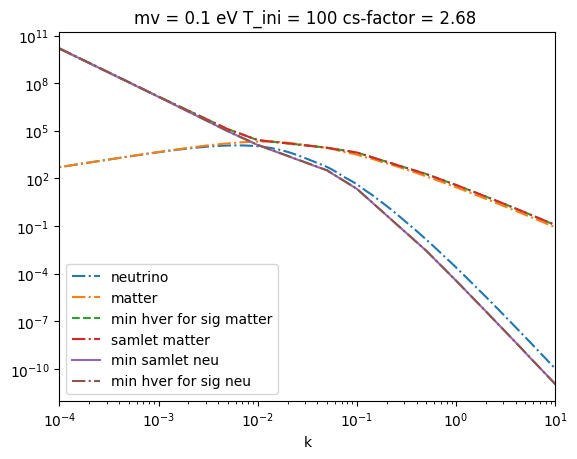

In [8]:
mv = 1e-1
e = simuler(mv,kvec=kvec,T_ini=100,k_special=5e-2)
e

In [9]:
"""mv = 5e-2
f = simuler(mv,kvec=kvec,T_ini=100,k_special=5e-2)
f"""

'mv = 5e-2\nf = simuler(mv,kvec=kvec,T_ini=100,k_special=5e-2)\nf'

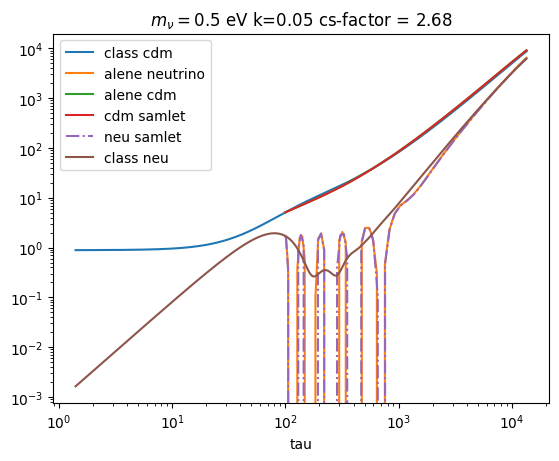

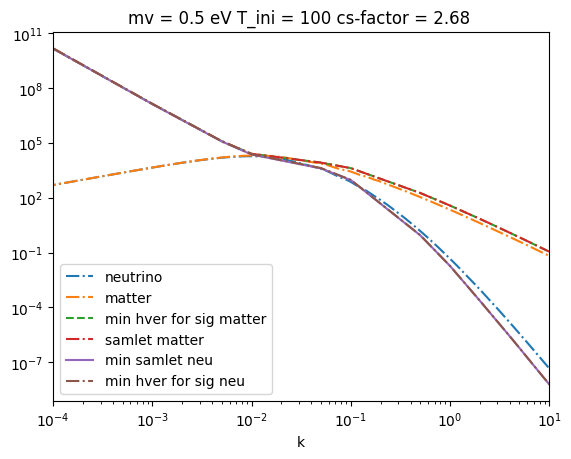

In [10]:
mv = 5e-1
g = simuler(mv,kvec=kvec,T_ini=100,k_special=5e-2)
g

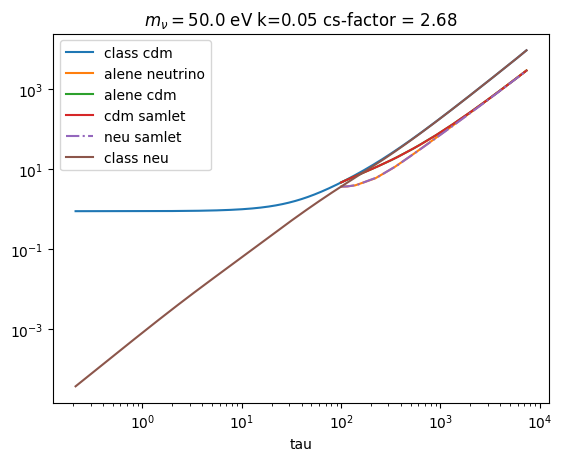

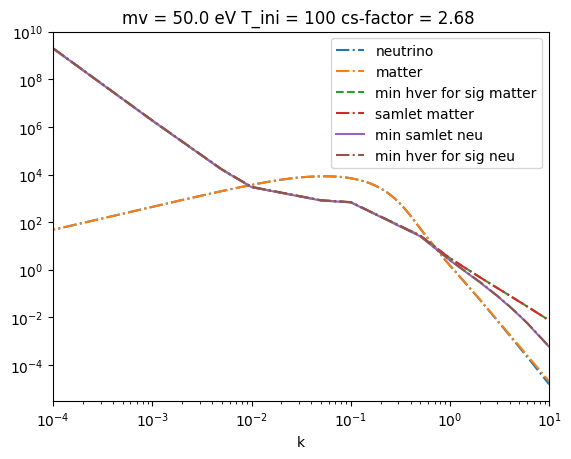

In [11]:
mv = 5e1
g = simuler(mv,kvec=kvec,T_ini=100,k_special=5e-2)
g

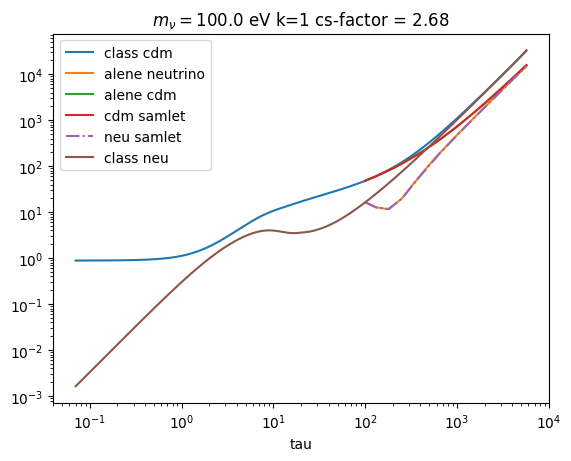

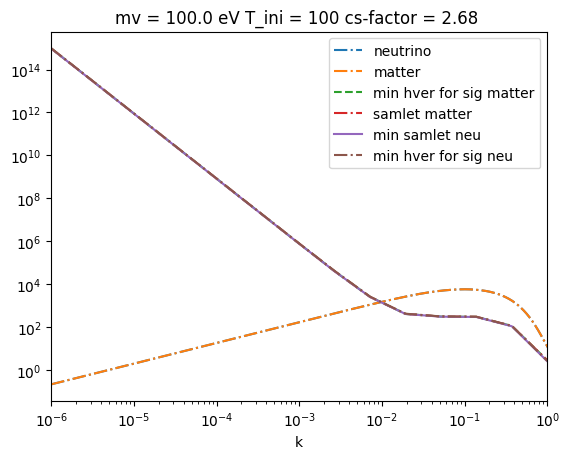

In [12]:
mv_test = 1e2
kvec = list(np.logspace(-6,0,15))
simuler(mv_test, # eV
        kvec,factor = 2.68,T_ini = 100)

[0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 2, 3, 4, 5, 6, 10.0]


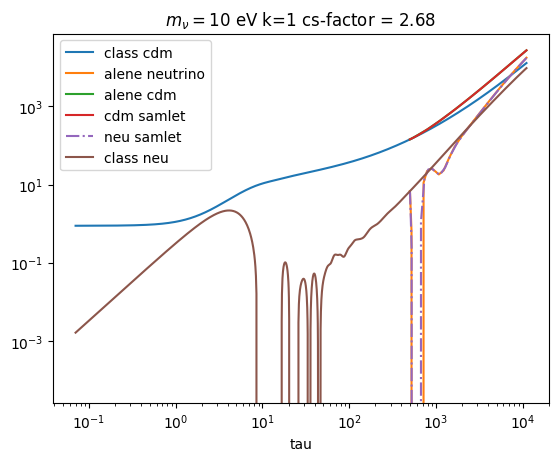

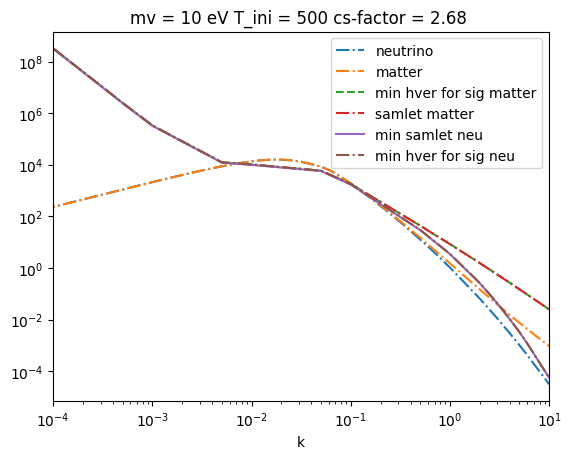

In [13]:
mv = 10

kvec = [1e-4,5e-4,1e-3,5e-3,1e-2,5e-2,1e-1,5e-1,1,2,3,4,5,6,1e1]
print(kvec)
a = simuler(mv,kvec=kvec,T_ini=500)
a

[0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 2, 3, 4, 5, 6, 10.0]


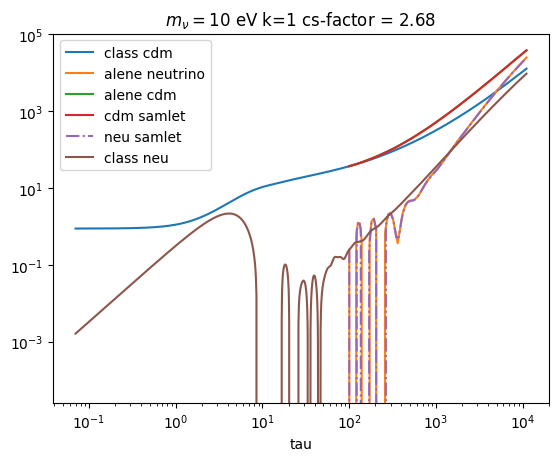

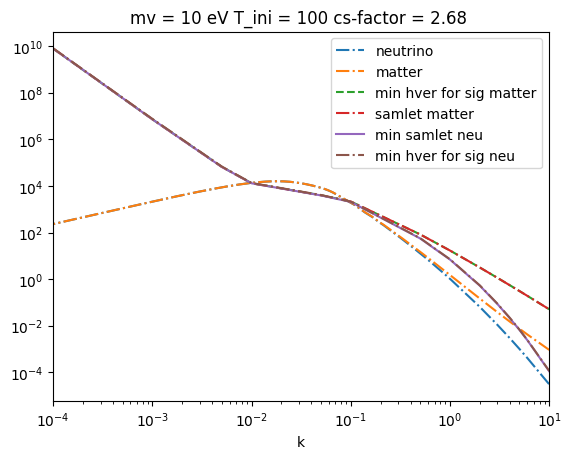

In [14]:
mv = 10

kvec = [1e-4,5e-4,1e-3,5e-3,1e-2,5e-2,1e-1,5e-1,1,2,3,4,5,6,1e1]
print(kvec)
a = simuler(mv,kvec=kvec,T_ini=100)
a

[0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 2, 3, 4, 5, 6, 10.0]


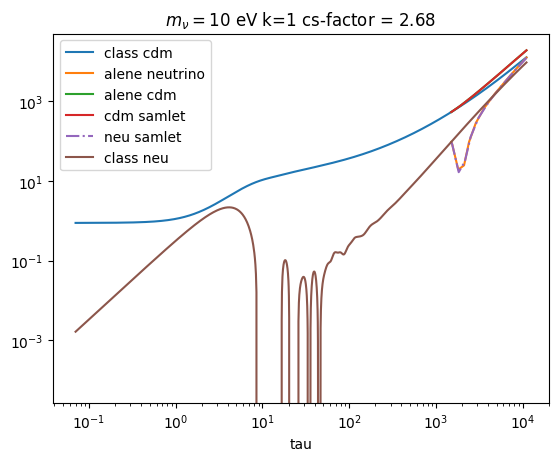

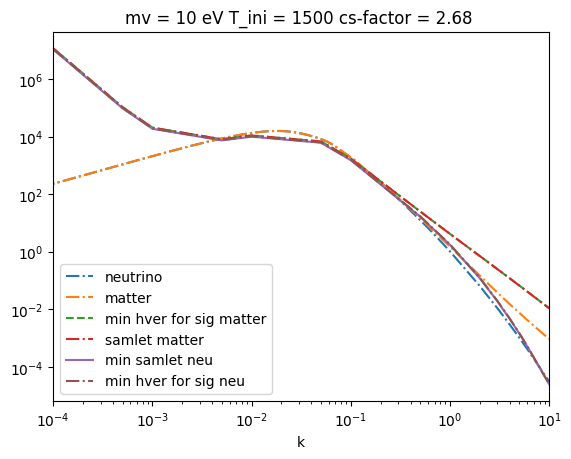

In [15]:
mv = 10

kvec = [1e-4,5e-4,1e-3,5e-3,1e-2,5e-2,1e-1,5e-1,1,2,3,4,5,6,1e1]
print(kvec)
a = simuler(mv,kvec=kvec,T_ini=1500)
a

[0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 2, 3, 4, 5, 6, 10.0]


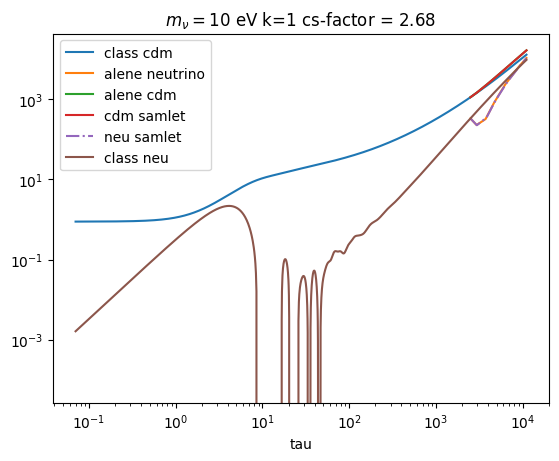

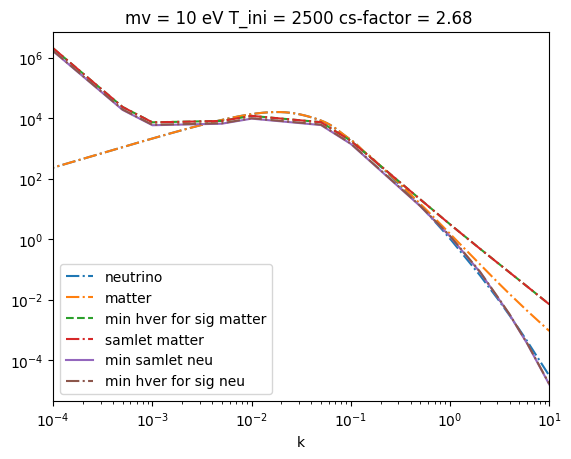

In [16]:
mv = 10

kvec = [1e-4,5e-4,1e-3,5e-3,1e-2,5e-2,1e-1,5e-1,1,2,3,4,5,6,1e1]
print(kvec)
a = simuler(mv,kvec=kvec,T_ini=2500)
a

[0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 2, 3, 4, 5, 6, 10.0]


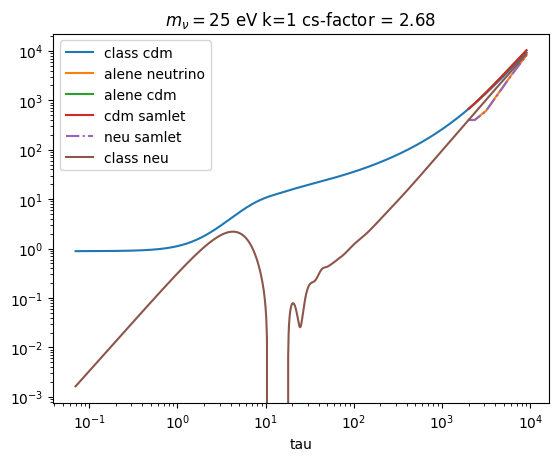

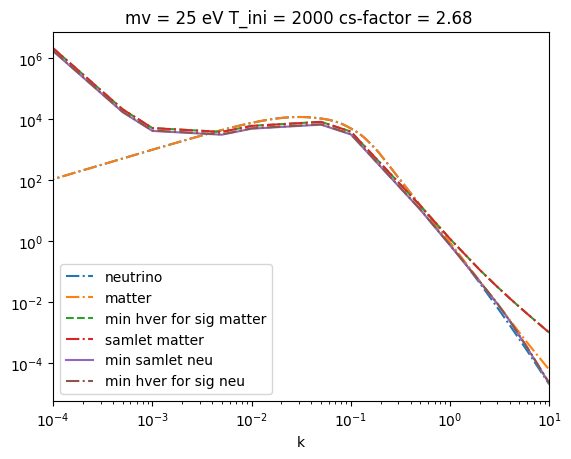

In [17]:
mv = 25

kvec = [1e-4,5e-4,1e-3,5e-3,1e-2,5e-2,1e-1,5e-1,1,2,3,4,5,6,1e1]
print(kvec)
a = simuler(mv,kvec=kvec,T_ini=2000)
a

[0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 2, 3, 4, 5, 6, 10.0]


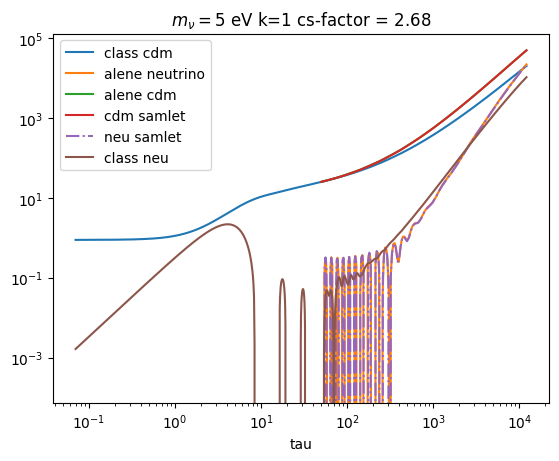

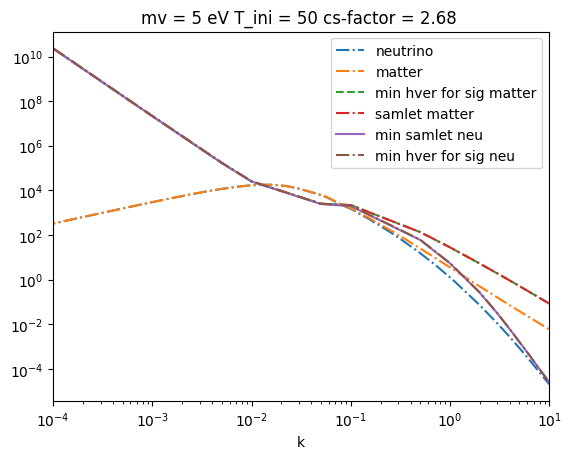

In [18]:
mv = 5

kvec = [1e-4,5e-4,1e-3,5e-3,1e-2,5e-2,1e-1,5e-1,1,2,3,4,5,6,1e1]
print(kvec)
a = simuler(mv,kvec=kvec,T_ini=50)
a

[-0.04233069 -0.06668102 -0.14825132 -0.38906302]
(delta_cdm1[0] / a[0] )=-85088.37080388512


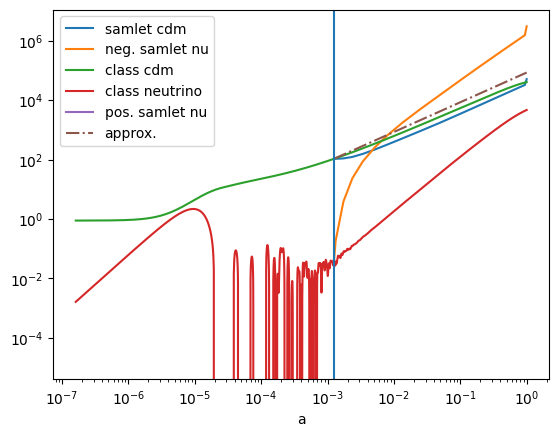

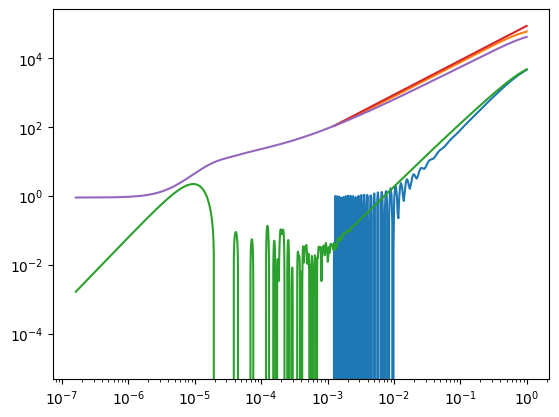

In [3]:
def f(mv_test,kvec,k_ind,H0=67,T_ini=1000):

    Res = np.zeros(len(kvec))
    Res1 = np.zeros(len(kvec))
    Res2 = np.zeros(len(kvec))
    Res4 = np.zeros(len(kvec))
    Omega_M = 0.3
    Omega_R = 7e-5
    Omega_lambda = 1 - Omega_M - Omega_R
    Tv_k = 1.947
    # in MeV
    kb = 8.617e-11 # MeV/K
    T0 = Tv_k * kb
    # 
    h = 0.6704
    cosmo_dict ={'H0':H0, 'Omega_cdm':Omega_M, 'k_output_values':str(kvec).strip('[]'), "N_ncdm":1,
                 "m_ncdm":mv_test # massen er givet i eV s' jeg min egen test m_v skal være en faktor  1e-6 mindre
               ,'output':'tCl, lCl, dTk, vTk, pCl', 'lensing':'yes',
                "ncdm_fluid_approximation":3
                }
    H0 /= (3*1e5) # i 1/Mpc
    cosmo = Class()
    cosmo.set(cosmo_dict)
    cosmo.compute()
    bg = cosmo.get_background()
    pts = cosmo.get_perturbations()['scalar']
    #print(bg.keys())
    z = bg["z"]
    a = 1/(z+1)
    aend = a[-1]
    a0 = a[0]
    mv = mv_test * 1e-6
    # cs front faktoren



    # udregner Hubbleparameteren

    def H(a):
        return H0 * np.sqrt(Omega_lambda + Omega_M /( a **3) + Omega_R /( a**4)) 

    # udregnger tau 

    def tau_cal(a,y):
        # Vores "tids"-værdi i denne differentialligning er a
        tau = y[0]
        d_tau = 1 / (a ** 2 * H(a))
        return np.array(d_tau)

    # temperatur

    def Tv(a):
        return T0 / a # in MeV

    # lydhastighed

    def cs(a,mv,factor):
        return factor * Tv(a) / mv

    # udregn a
    def a_solve(tau,y):
        a = y[0]
        a_dt = a * a * H(a)
        return [a_dt]

    tau_init =   (1/H0) * (Omega_R ** (-0.5)) * a0


    sol_tau = sc.solve_ivp(tau_cal,t_span=[a0,aend],y0=[tau_init])
    tau = sol_tau.y[0]

    sol_a = sc.solve_ivp(a_solve,t_span=[tau[0],tau[-1]],y0=[a0])
    a_tau = sol_a.t
    a = sol_a.y[0]

    a_interp = scipy.interpolate.interp1d(a_tau,a)

    # simulerings funktionerne

    def func_det_hele(τ,y,k,mv,factor):
        delta = y[0]
        theta = y[1]    
        a = a_interp(τ)
        d_delta   = - theta
        d_theta      =  -  H(a) * a * theta    - (3/2) * H0*H0 * Omega_M * delta / a
        delta_nu = y[2]
        theta_nu = y[3]
        d_delta_nu   = - theta_nu
        d_theta_nu   =  -  H(a) * a * theta_nu - (3/2) * H0*H0 * Omega_M * delta / a  + k**2 * cs(a,mv,factor)**2 * delta_nu
        return [d_delta,d_theta,d_delta_nu,d_theta_nu]

    def func(a,y):
        delta = y[0]
        d_delta = y[1]
        #a = a_interp(τ)
        dd_delta = -3/2 * (1/a) * d_delta + 3/2 *(1/a)**2 * delta
        return [d_delta,dd_delta]
    
    delta_class = pts[k_ind]["delta_cdm"]
    theta_class = pts[k_ind]["theta_cdm"]
    tau_class = pts[k_ind]["tau [Mpc]"]
    delta_neutrino_class = pts[k_ind]["delta_ncdm[0]"]
    theta_neutrino_class = pts[k_ind]["theta_ncdm[0]"]
    a_class = pts[k_ind]["a"]

    interp_tau_from_a = scipy.interpolate.interp1d(a_class,tau_class)
    
    z = 3600
    z = 800
    #z = 3000
    a0 = 1/(1+z)
    T_ini = interp_tau_from_a(a0)
    a_span = [a0,1]
    
    delta_init = scipy.interpolate.interp1d(tau_class,delta_class)(T_ini)
    theta_init = scipy.interpolate.interp1d(tau_class,theta_class)(T_ini)
    delta_neutrino_init = scipy.interpolate.interp1d(tau_class,delta_neutrino_class)(T_ini)
    theta_neutrino_init = scipy.interpolate.interp1d(tau_class,theta_neutrino_class)(T_ini)

    #y0 = [delta_init,theta_init,delta_neutrino_init,theta_neutrino_init]
    y0 = [delta_init,-theta_init]
    #sol_en = sc.solve_ivp(func_det_hele, t_span = τ_span, y0 = y0,args=(k,mv,factor))
    sol = sc.solve_ivp(func,t_span=a_span,y0 = y0)
    a = sol.t
    delta = sol.y[0]
    delta_interp = scipy.interpolate.interp1d(a,delta)
    #τ_cdm_en = sol_en.t
    #delta_cdm_en = sol_en.y[0]
    #delta_nu_en = sol_en.y[2]

    #plt.loglog(tau_class,-delta_class)
    #plt.loglog(a_class,-delta_class)
    ##print(delta)
    #plt.loglog(a,-delta)
    #plt.axvline(a0)
    #plt.title("delta(a) test k = %s mv= %s eV"%(kvec[k_ind],mv_test))
    #plt.xlabel("a")
    #plt.figure(134)
    
    def func1(a,y,n,mv,factor,k,A):
        delta = y[0]
        theta = y[1]
        #a = a_interp(τ)
        #A = delta_class[0] / (a**(n))
        delta_cdm = A * a** n
        d_delta = - theta
        d_theta =  -  H(a) * a * theta - (3/2) * H0*H0 * Omega_M * delta_cdm / a  + k**2 * cs(a,mv,factor)**2 * delta
        return [d_delta,d_theta]
    
    def F(a,y,k,mv,factor,A):
        delta_cdm = y[0]
        d_delta_cdm = y[1]
        delta_nu = y[2]
        d_delta_nu = y[3]
        d2_delta_cdm = - 3/2 * 1/a * d_delta_cdm + 3/2 * 1/a**2 *delta_cdm
        d2_delta_nu = + (k**2 * cs(a,mv,factor)**2)/(a*Omega_M) * delta_nu+ 1/2 * 1/a * d_delta_nu + 3/2 *1/a * A# * a#delta_cdm 
        return [d_delta_cdm,d2_delta_cdm,d_delta_nu,d2_delta_nu]
    
    
    def F1(a,y,k,mv,factor,A):
        delta_cdm = y[0]
        d_delta_cdm = y[1]
        delta_nu = y[2]
        d_delta_nu = y[3]
        d2_delta_cdm = - 3/2 * 1/a * d_delta_cdm + 3/2 * 1/a**2 *delta_cdm
        d2_delta_nu = + (k**2 * cs(a,mv,factor)**2)/(a*Omega_M) * delta_nu+ 1/2 * 1/a * d_delta_nu + 3/2 * delta_cdm/(a**2)  
        return [d_delta_cdm,d2_delta_cdm,d_delta_nu,d2_delta_nu]
        
        
    
    #plt.loglog(a_class,-delta_class,label="class cdm")
    #print(delta)
    n= 0.9
    A = delta[0] / (a[0]**(n))
    #plt.loglog(a,-A * a** n,"-.",label="a^%s"%n)
    n= 1
    A = delta[0] / (a[0]**(n))
    #plt.loglog(a,-A * a** n,"-.",label="a^%s"%n)
    n= 0.85
    A = delta[0] / (a[0]**(n))
    #plt.loglog(a,-A * a** n,"-.",label="a^%s"%n)
    
    y0 = [delta_neutrino_init,-theta_neutrino_init]
    #sol_en = sc.solve_ivp(func_det_hele, t_span = τ_span, y0 = y0,args=(k,mv,factor))
    
    
    n = 1
    k = kvec[k_ind]
    cs_factor = 2.67
    A =  delta_init / (a_span[0]**(n))
    sol = sc.solve_ivp(func1,t_span=a_span,y0 = y0,args=(n,mv,cs_factor,k,A))
    #,t_eval=np.logspace(np.log10(a_span[0]),0,50))
    a = sol.t
    delta = sol.y[0]
    print(delta)
    #plt.axvline(a0)
    #plt.title("For the meme")
    #
    #plt.loglog(a_class,-delta_neutrino_class,label="class neutrino")
    #plt.loglog(a,delta,label="min neu - positive")
    #plt.loglog(a,-delta,label="min neu - negative")
    #plt.xlabel("a")
    #plt.legend(loc="upper left")
    
    y1 = [delta_init,-theta_init,delta_neutrino_init,-theta_neutrino_init]
    A =  delta[0] / (a_span[0]**(1))
    sol = sc.solve_ivp(F,t_span=a_span,y0=y1,args=(k,mv,cs_factor,A))
    
    a = sol.t
    delta_cdm = sol.y[0]
    delta_nu = sol.y[2]
    
    #plt.figure(2132)
    #
    #
    #plt.loglog(a,-delta_cdm,label="samlet cdm")
    #plt.loglog(a,-delta_nu,label="neg. samlet nu")
    #plt.loglog(a_class,-delta_class,label="class cdm")
    #plt.loglog(a_class,-delta_neutrino_class,label="class neutrino")
    #plt.loglog(a,delta_nu,label="pos. samlet nu")
    #A = delta_cdm[0] / a[0]
    #plt.loglog(a,-A*a,"-.",label="approx.")
    #plt.xlabel("a")
    #plt.axvline(a0)
    #plt.legend(loc="upper left")
    A =  delta[0] / (a_span[0]**(1))
    sol1 = sc.solve_ivp(F1,t_span=a_span,y0=y1,args=(k,mv,cs_factor,A))
    
    a = sol.t
    delta_cdm = sol1.y[0]
    delta_nu = sol1.y[2]
    plt.figure(11323223)
    plt.loglog(a,-delta_cdm,label="samlet cdm")
    plt.loglog(a,-delta_nu,label="neg. samlet nu")
    plt.loglog(a_class,-delta_class,label="class cdm")
    plt.loglog(a_class,-delta_neutrino_class,label="class neutrino")
    plt.loglog(a,delta_nu,label="pos. samlet nu")
    A = delta_cdm[0] / a[0]
    plt.loglog(a,-A*a,"-.",label="approx.")
    plt.xlabel("a")
    plt.axvline(a0)
    plt.legend(loc="upper left")
    
    cs_factor = 2.67
    beta = ((cs_factor*k*T0)/(H0*mv))**2 / Omega_M
    delta0 = delta_init

    def f(a,c1):
        return np.exp(1/3 * (beta * (1/a**2 -1) + (a**2 -1))) * (c1 - delta0/(3*a0) * (np.exp(1-beta/2) - np.exp(a**2 / 2 - beta/(2*a))*(1/a) * np.exp(-beta * np.log(a))))

    a = a_class
    
    #np.logspace(a0,0,30)
    #plt.figure(1212222)
    #plt.loglog(a_class,-delta_neutrino_class)
    #plt.loglog(a,-f(a,0))
    ##plt.loglog(a,-f(a,0))
    #plt.figure(12312122)
    #plt.loglog(a,-f(a,0))
    #plt.loglog(a,f(a,0))
    
    k = kvec[k_ind]
    delta_cdm1 = sol1.y[0]
    def func1(a,y,mv,cs_factor,k):
        delta = y[0]
        theta = y[1]
        delta_cdm = y[2]
        
        theta_cdm = y[3]
        
        d_delta_cdm = 1/(a**2 * H(a)) * (-theta_cdm)
        d_theta_cdm = 1/(a**2 * H(a))*(-a*H(a)*theta_cdm - 3/2 * H0**2 * Omega_M/a * delta_cdm)
        d_delta = -theta/(a**2 * H(a))
        d_theta = 1/(a**2 * H(a)) * (-a*H(a)*theta-3/2 *H0**2* Omega_M /a * delta_cdm + k**2 * cs(a,mv,cs_factor)**2 * delta)
        return [d_delta,d_theta,d_delta_cdm,d_theta_cdm]
    
    
    y0 =[delta_neutrino_init,theta_neutrino_init,delta_init,theta_init]
    #print(a_span)
    sol = scipy.integrate.solve_ivp(func1,a_span,y0,args=(mv,cs_factor,k))
    plt.figure(333333)
    plt.loglog(sol.t,-sol.y[0])
    plt.loglog(sol.t,-sol.y[2])
    plt.loglog(a_class,-delta_neutrino_class)
    a = sol.t
    #print(delta_cdm1)
    delta  = a * (delta_cdm1[0] / a[0] )
    print(f"{(delta_cdm1[0] / a[0] )=}")
    #print(delta)
    plt.loglog(a,-delta)
    plt.loglog(a_class,-delta_class)
    
    return None

kvec = [1e-2,1e-1,1,1e1]
mv = 1
f(mv,kvec = kvec,k_ind=2)


In [ ]:

f(mv,kvec = kvec,k_ind=1)

In [ ]:

f(mv,kvec = kvec,k_ind=2)

[ 0.0156331   0.01562057  0.01560576  0.01558825  0.01556756  0.01554311
  0.0155142   0.01548005  0.01543967  0.01539195  0.01533555  0.01526889
  0.0151901   0.01509698  0.01498691  0.01485682  0.01470305  0.01452131
  0.01430649  0.01405258  0.01375247  0.01339775  0.01297849  0.01248295
  0.01189726  0.01120505  0.01038698  0.00942019  0.00827765  0.00692738
  0.00533137  0.003445    0.00121552 -0.00141949 -0.00453379 -0.00821456
 -0.01256482 -0.01770635 -0.02378307 -0.03096507 -0.03945339 -0.04948561
 -0.06134255 -0.07535606 -0.09191838 -0.11149307 -0.13462798 -0.16197057
 -0.194286   -0.2324784 ]


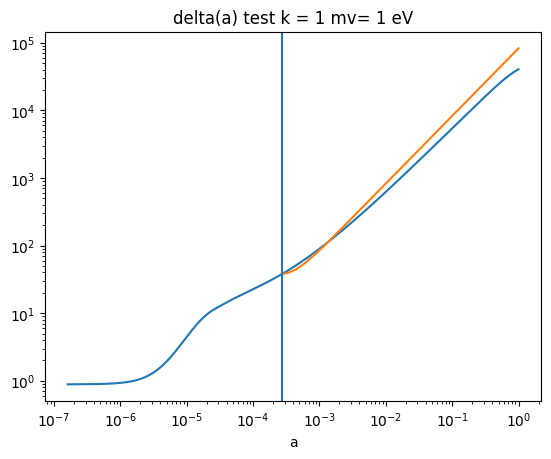

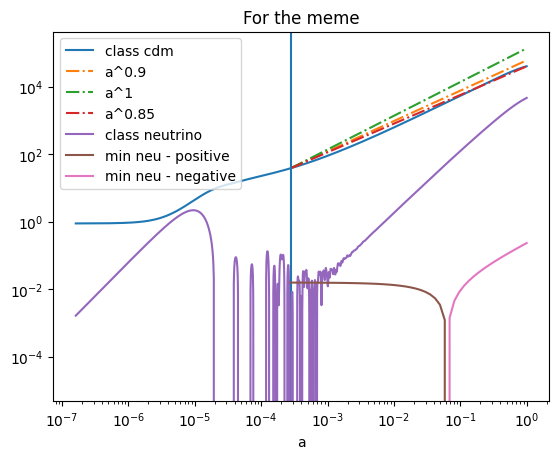

In [21]:
f(mv,kvec = kvec,k_ind=2)

[ 1.05528198e-03  1.03231526e-03  1.00517024e-03  9.73086662e-04
  9.35165912e-04  8.90345857e-04  8.37371090e-04  7.74757788e-04
  7.00752201e-04  6.13281638e-04  5.09896601e-04  3.87702495e-04
  2.43279037e-04  7.25851087e-05 -1.29153747e-04 -3.67578820e-04
 -6.49357808e-04 -9.82378268e-04 -1.37598489e-03 -1.84119692e-03
 -2.39102813e-03 -3.04087000e-03 -3.80891352e-03 -4.71665846e-03
 -5.78951517e-03 -7.05751582e-03 -8.55615522e-03 -1.03273839e-02
 -1.24207821e-02 -1.48949477e-02 -1.78191369e-02 -2.12752025e-02
 -2.53598855e-02 -3.01875237e-02 -3.58932528e-02 -4.26367888e-02
 -5.06068968e-02 -6.00266659e-02 -7.11597412e-02 -8.43177496e-02
 -9.98689808e-02 -1.18248701e-01 -1.39971336e-01 -1.65644873e-01
 -1.95987872e-01 -2.31849573e-01 -2.74233643e-01 -3.24326203e-01
 -3.83528876e-01 -4.53498071e-01]


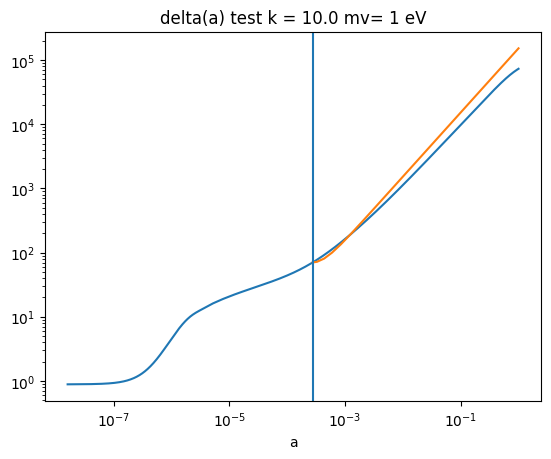

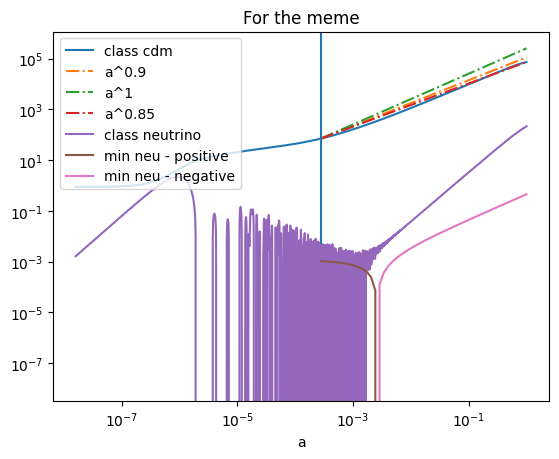

In [22]:
f(mv,kvec = kvec,k_ind=-1)

[ 0.0156331   0.01562057  0.01560576  0.01558825  0.01556756  0.01554311
  0.0155142   0.01548005  0.01543967  0.01539195  0.01533555  0.01526889
  0.0151901   0.01509698  0.01498691  0.01485682  0.01470305  0.01452131
  0.01430649  0.01405258  0.01375247  0.01339775  0.01297849  0.01248295
  0.01189726  0.01120505  0.01038698  0.00942019  0.00827765  0.00692738
  0.00533137  0.003445    0.00121552 -0.00141949 -0.00453379 -0.00821456
 -0.01256482 -0.01770635 -0.02378307 -0.03096507 -0.03945339 -0.04948561
 -0.06134255 -0.07535606 -0.09191838 -0.11149307 -0.13462798 -0.16197057
 -0.194286   -0.2324784 ]


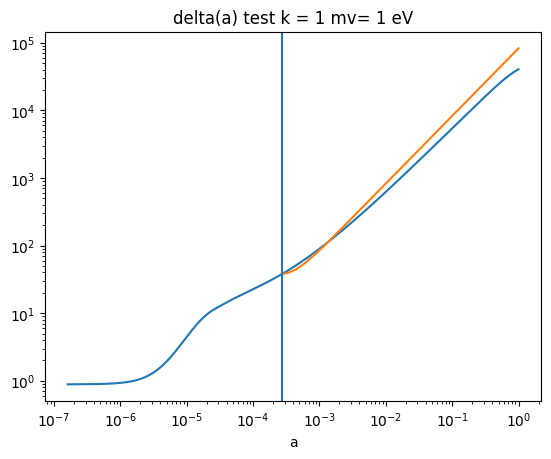

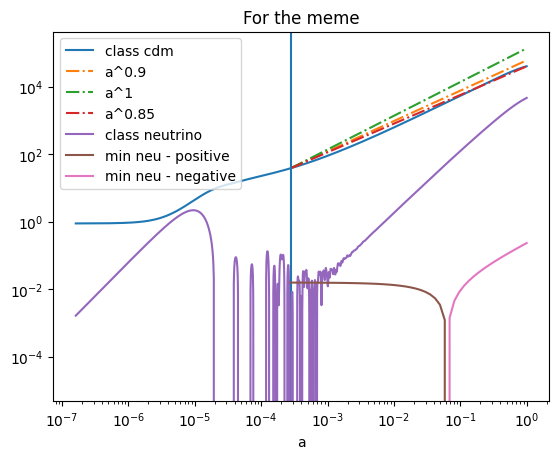

In [23]:
f(mv,kvec = kvec,k_ind=2)

In [44]:
"""a = np.logspace(-3,0,100)

def H(a):
    H0 = 67.040/(3*1e5) 
    Omega_M = 0.3
    Omega_R = 7e-5
    Omega_lambda = 1 - Omega_M - Omega_R
    res1= H0 * (Omega_M*a**(-3) + Omega_lambda)**0.5
    res = H0 * Omega_M**(0.5)* (1+ 1/2 * Omega_M / Omega_lambda * a**-3)
    res2 = H0 * (Omega_M*a**(-3))**(0.5) * (1 + 0.5 * Omega_lambda/Omega_M * a**3)
    return res,res1,res2

r,r1,r2 = H(a)

plt.loglog(a,r,"b")
plt.loglog(a,r1,"g")
plt.loglog(a,r2,"-.",color="r")"""

'a = np.logspace(-3,0,100)\n\ndef H(a):\n    H0 = 67.040/(3*1e5) \n    Omega_M = 0.3\n    Omega_R = 7e-5\n    Omega_lambda = 1 - Omega_M - Omega_R\n    res1= H0 * (Omega_M*a**(-3) + Omega_lambda)**0.5\n    res = H0 * Omega_M**(0.5)* (1+ 1/2 * Omega_M / Omega_lambda * a**-3)\n    res2 = H0 * (Omega_M*a**(-3))**(0.5) * (1 + 0.5 * Omega_lambda/Omega_M * a**3)\n    return res,res1,res2\n\nr,r1,r2 = H(a)\n\nplt.loglog(a,r,"b")\nplt.loglog(a,r1,"g")\nplt.loglog(a,r2,"-.",color="r")'

In [82]:
n = 5
v = np.ones(n)*1/3
A = np.diag(v, -1)[:-1, :-1] + np.diag(v, 0) + np.diag(v, 1)[:-1, :-1]
A

array([[0.33333333, 0.33333333, 0.        , 0.        , 0.        ],
       [0.33333333, 0.33333333, 0.33333333, 0.        , 0.        ],
       [0.        , 0.33333333, 0.33333333, 0.33333333, 0.        ],
       [0.        , 0.        , 0.33333333, 0.33333333, 0.33333333],
       [0.        , 0.        , 0.        , 0.33333333, 0.33333333]])

delta_neutrino_init=array(-0.19077922)


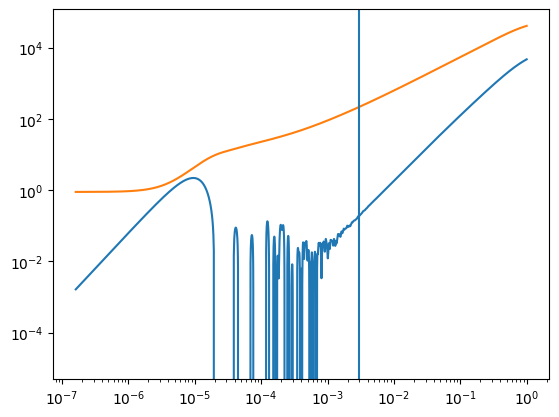

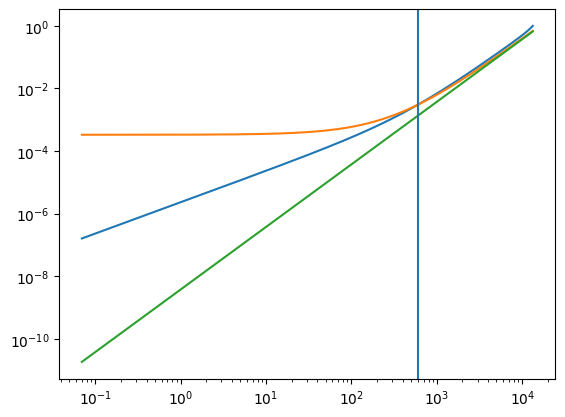

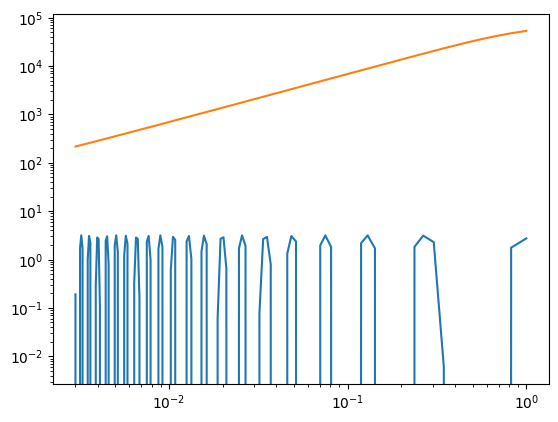

In [19]:
mv_test = 1
kvec = [1]
k_ind = 0
H0=67
Omega_M = 0.3
Omega_R = 7e-5
Omega_lambda = 1 - Omega_M - Omega_R
Tv_k = 1.947
# in MeV
kb = 8.617e-11 # MeV/K
T0 = Tv_k * kb
# 
h = 0.6704
cs_factor = 2.67
cosmo_dict ={'H0':H0, 'Omega_cdm':Omega_M, 'k_output_values':str(kvec).strip('[]'), "N_ncdm":1,
             "m_ncdm":mv_test # massen er givet i eV s' jeg min egen test m_v skal være en faktor  1e-6 mindre
           ,'output':'tCl, lCl, dTk, vTk, pCl', 'lensing':'yes',
            "ncdm_fluid_approximation":3
            }
H0 /= (3*1e5) # i 1/Mpc
cosmo = Class()
cosmo.set(cosmo_dict)
cosmo.compute()
bg = cosmo.get_background()
pts = cosmo.get_perturbations()['scalar']
#print(bg.keys())
z = bg["z"]
a = 1/(z+1)
aend = a[-1]
a0 = a[0]
mv = mv_test * 1e-6
# cs front faktoren



    # udregner Hubbleparameteren

def H(a):
    return H0 * np.sqrt(Omega_lambda + Omega_M /( a **3) + Omega_R /( a**4)) 

# udregnger tau 

def tau_cal(a,y):
    # Vores "tids"-værdi i denne differentialligning er a
    tau = y[0]
    d_tau = 1 / (a ** 2 * H(a))
    return np.array(d_tau)

# temperatur

def Tv(a):
    return T0 / a # in MeV

# lydhastighed

def cs(a,mv,factor):
    return factor * Tv(a) / mv

# udregn a
def a_solve(tau,y):
    a = y[0]
    a_dt = a * a * H(a)
    return [a_dt]

delta_class = pts[k_ind]["delta_cdm"]
theta_class = pts[k_ind]["theta_cdm"]
tau_class = pts[k_ind]["tau [Mpc]"]
delta_neutrino_class = pts[k_ind]["delta_ncdm[0]"]
theta_neutrino_class = pts[k_ind]["theta_ncdm[0]"]
a_class = pts[k_ind]["a"]

interp_tau_from_a = scipy.interpolate.interp1d(a_class,tau_class)

z = 3600
z = 800
z = 332
#z = 3000
a0 = 1/(1+z)
T_ini = interp_tau_from_a(a0)
a_span = [a0,1]

delta_init = scipy.interpolate.interp1d(tau_class,delta_class)(T_ini)
theta_init = scipy.interpolate.interp1d(tau_class,theta_class)(T_ini)
delta_neutrino_init = scipy.interpolate.interp1d(tau_class,delta_neutrino_class)(T_ini)
theta_neutrino_init = scipy.interpolate.interp1d(tau_class,theta_neutrino_class)(T_ini)
print(f"{delta_neutrino_init=}")
#y0 = [delta_init,theta_init,delta_neutrino_init,theta_neutrino_init]
y0 = [delta_init,-theta_init]
k=1
def func1(a,y,mv,cs_factor,k):
    delta = y[0]
    theta = y[1]
    delta_cdm = y[2]

    theta_cdm = y[3]

    d_delta_cdm = 1/(a**2 * H(a)) * (-theta_cdm)
    d_theta_cdm = 1/(a**2 * H(a))*(-a*H(a)*theta_cdm - 3/2 * H0**2 * Omega_M/a * delta_cdm)
    d_delta = -theta/(a**2 * H(a))
    d_theta = 1/(a**2 * H(a)) * (-a*H(a)*theta + k**2 * cs(a,mv,cs_factor)**2 * delta)#-3/2 *H0**2* Omega_M /a * delta_cdm
    return [d_delta,d_theta,d_delta_cdm,d_theta_cdm]


y0 =[delta_neutrino_init,theta_neutrino_init,delta_init,theta_init]
#print(a_span)
sol = scipy.integrate.solve_ivp(func1,a_span,y0,args=(mv,cs_factor,k))
plt.figure(333333)

def paste():
    plt.loglog(sol.t,-sol.y[0])
    plt.loglog(sol.t,-sol.y[2])
    return None
plt.loglog(a_class,-delta_neutrino_class)

plt.loglog(a_class,-delta_class)
plt.axvline(a0)
a = sol.t
#print(delta_cdm1)
plt.figure(8888)
plt.loglog(tau_class,a_class)
plt.loglog(tau_class,(1/2 * H0 * np.sqrt(Omega_M) * (tau_class-T_ini)+np.sqrt(a0))**2)
plt.loglog(tau_class,1/4 * H0**2 * Omega_M * tau_class**2)
plt.axvline(T_ini)
plt.figure(213)
paste()

Skærmbilled fram wolframaplha
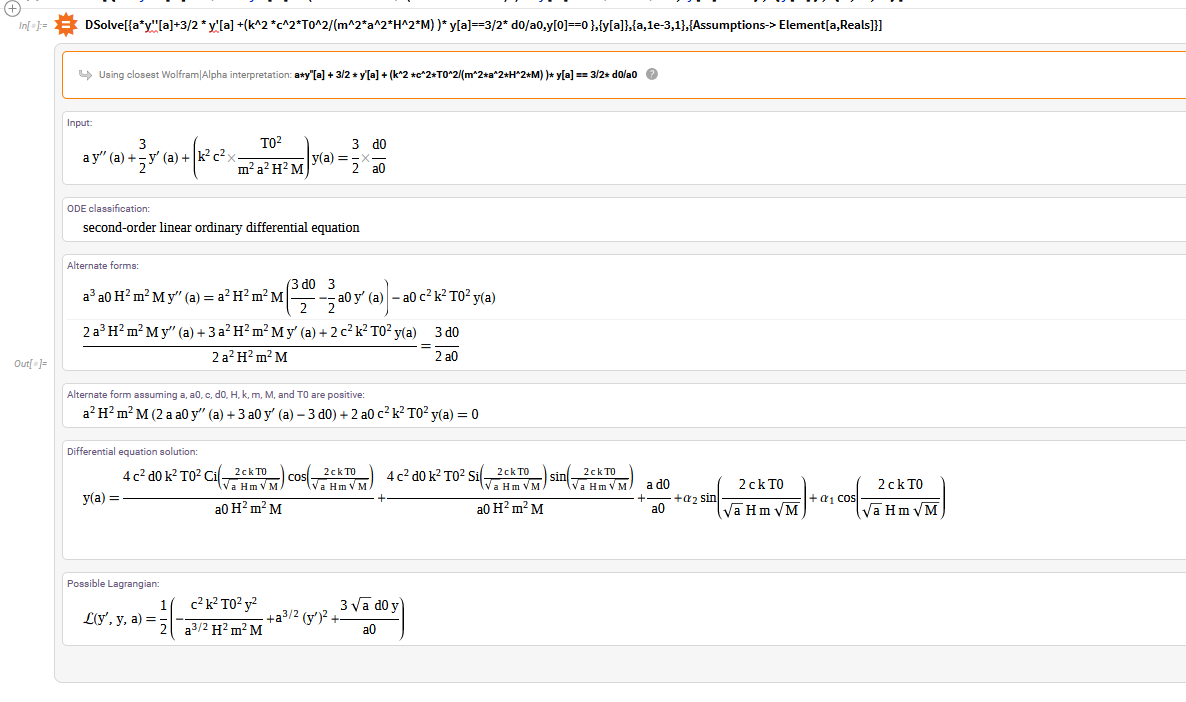


Den homogene løsning

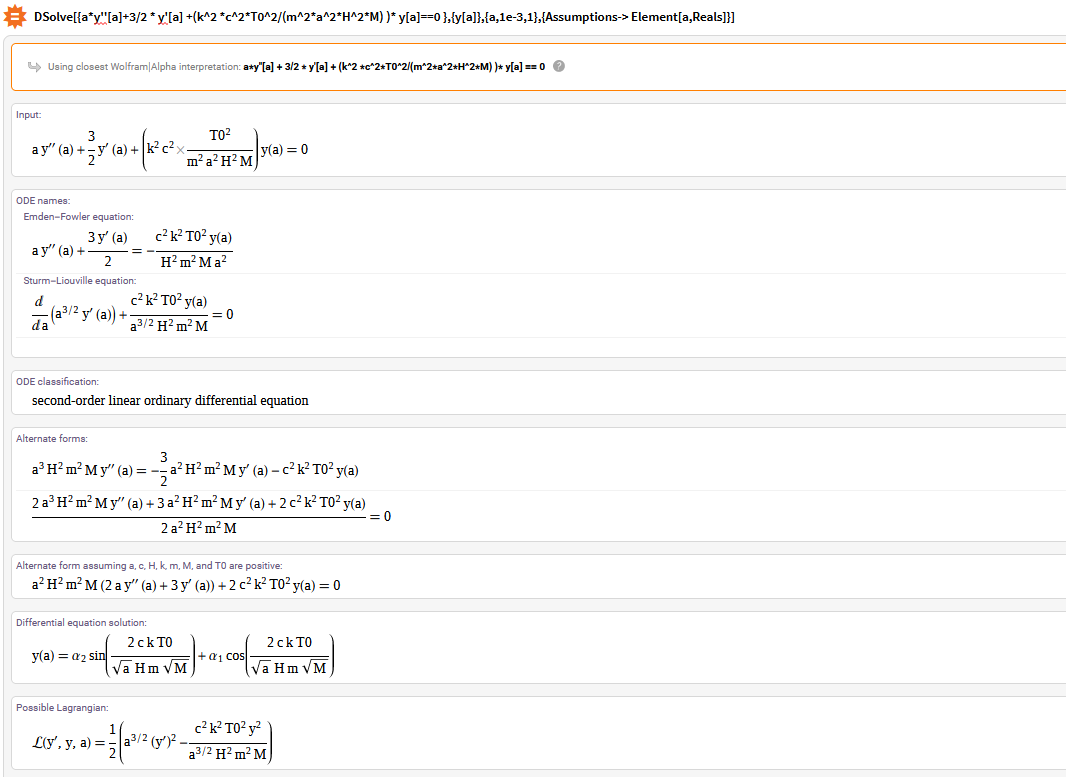

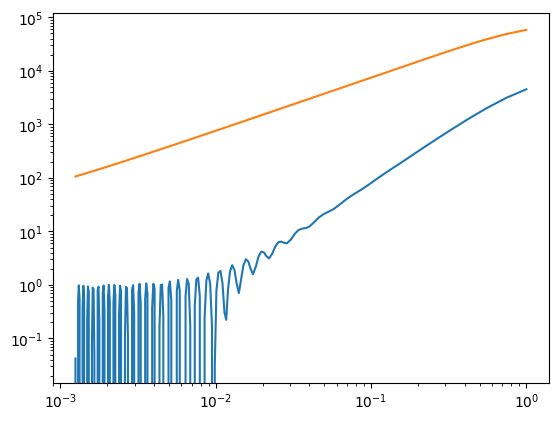

In [5]:
cs_factor = 2.67
import scipy.special as special
mv_test = 1
kvec = [1]
k_ind = 0
k = kvec[k_ind]
H0=67
Omega_M = 0.3
Omega_R = 7e-5
Omega_lambda = 1 - Omega_M - Omega_R
Tv_k = 1.947
# in MeV
kb = 8.617e-11 # MeV/K
T0 = Tv_k * kb
# 
h = 0.6704
cosmo_dict ={'H0':H0, 'Omega_cdm':Omega_M, 'k_output_values':str(kvec).strip('[]'), "N_ncdm":1,
             "m_ncdm":mv_test # massen er givet i eV s' jeg min egen test m_v skal være en faktor  1e-6 mindre
           ,'output':'tCl, lCl, dTk, vTk, pCl', 'lensing':'yes',
            "ncdm_fluid_approximation":3
            }
H0 /= (3*1e5) # i 1/Mpc
cosmo = Class()
cosmo.set(cosmo_dict)
cosmo.compute()
bg = cosmo.get_background()
pts = cosmo.get_perturbations()['scalar']
#print(bg.keys())
z = bg["z"]
a = 1/(z+1)
aend = a[-1]
a0 = a[0]
mv = mv_test * 1e-6
# cs front faktoren



    # udregner Hubbleparameteren

def H(a):
    return H0 * np.sqrt(Omega_lambda + Omega_M /( a **3) + Omega_R /( a**4)) 

# udregnger tau 

def tau_cal(a,y):
    # Vores "tids"-værdi i denne differentialligning er a
    tau = y[0]
    d_tau = 1 / (a ** 2 * H(a))
    return np.array(d_tau)

# temperatur

def Tv(a):
    return T0 / a # in MeV

# lydhastighed

def cs(a,mv,factor):
    return factor * Tv(a) / mv

# udregn a
def a_solve(tau,y):
    a = y[0]
    a_dt = a * a * H(a)
    return [a_dt]

delta_class = pts[k_ind]["delta_cdm"]
theta_class = pts[k_ind]["theta_cdm"]
tau_class = pts[k_ind]["tau [Mpc]"]
delta_neutrino_class = pts[k_ind]["delta_ncdm[0]"]
theta_neutrino_class = pts[k_ind]["theta_ncdm[0]"]
a_class = pts[k_ind]["a"]

interp_tau_from_a = scipy.interpolate.interp1d(a_class,tau_class)

z = 3600
z = 800
#z = 3000
a0 = 1/(1+z)
T_ini = interp_tau_from_a(a0)
a_span = [a0,1]

delta_init = scipy.interpolate.interp1d(tau_class,delta_class)(T_ini)
theta_init = scipy.interpolate.interp1d(tau_class,theta_class)(T_ini)
delta_neutrino_init = scipy.interpolate.interp1d(tau_class,delta_neutrino_class)(T_ini)
theta_neutrino_init = scipy.interpolate.interp1d(tau_class,theta_neutrino_class)(T_ini)

#y0 = [delta_init,theta_init,delta_neutrino_init,theta_neutrino_init]
y0 = [delta_init,-theta_init]
beta = ((cs_factor*k*T0)/(H0*mv))**2 / Omega_M
delta0 = delta_init
paste()


1.2834869932681512
-1159.5720057459343


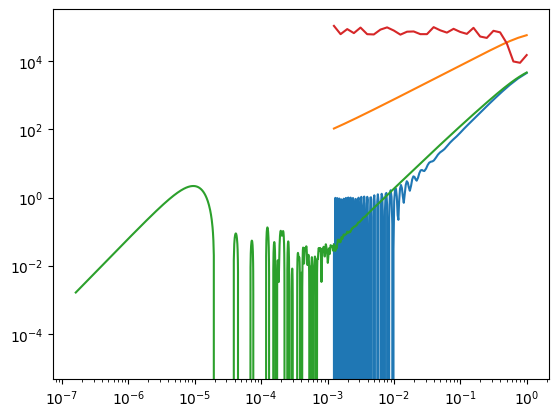

In [14]:
from scipy.special import sinc, sici

def g(a,c1,c2):
    val = 2*cs_factor*k*T0/(np.sqrt(a)*H0*mv*np.sqrt(Omega_M))
    si,ci = special.sici(val)
    return 4 * cs_factor**2 * delta0*k**2*T0/(a0*H0**2 * mv**2 * Omega_M) *(ci*np.cos(val)+si*np.sin(val)) + a *delta0/a0 + c1 * np.sin(val) + c2*np.cos(val)


print(np.sum(sici(1)))
print((-1e3-np.cos(2*k*cs(1,mv,cs_factor)/(H0*np.sqrt(Omega_M))))/np.sin(2*k*cs(1,mv,cs_factor)/(H0*np.sqrt(Omega_M))))


def g(a):
    c =  cs(1,mv,cs_factor) # alle factorerne i cs(a)
    
    return (c*delta0 * H0**2 * k * Omega_M-2*c**3 *delta0*k**3 * np.cos(((-2+126*np.sqrt(a))*c*k)/(np.sqrt(a)*H0*np.sqrt(Omega_M)) )*sinc(63*c*k/(H0*np.sqrt(Omega_M))) 
           +c**3 * delta0*k**3 * np.cos(2*c*k/(np.sqrt(a)*H0*np.sqrt(Omega_M))) * 
            ( -4*sici(63*c*k/(H0*np.sqrt(Omega_M)))[1]+4*sici(2*c*k/(np.sqrt(a)*H0*np.sqrt(Omega_M)))[1]+2*sinc(63*c*k/(H0*np.sqrt(Omega_M))))
           +c**3 * delta0*k**3 * np.sin(2*c*k/(np.sqrt(a)*H0*np.sqrt(Omega_M))) * 
            ( -4*sici(63*c*k/(H0*np.sqrt(Omega_M)))[0]+4*sici(2*c*k/(np.sqrt(a)*H0*np.sqrt(Omega_M)))[0])) /(a0*c*H0**2 * k *Omega_M)

paste()

plt.loglog(a_class,-delta_neutrino_class)
a = np.logspace(np.log10(a0),0,30)
#plt.loglog(a_class,delta_neutrino_class)
plt.loglog(a,-g(a))#,-1158,1))
#plt.loglog(a,-f(a,0))

![Sk%C3%A6rmbillede%202023-03-06%20083719.png](attachment:Sk%C3%A6rmbillede%202023-03-06%20083719.png)
